In [1]:
# Install system dependencies
!apt-get update && apt-get install -y \
    python3-dev \
    swig \
    python3-pygame \
    libsdl2-dev \
    libjpeg-dev \
    zlib1g-dev

# Install Python packages
!pip install "pettingzoo[atari]==1.24.3" gymnasium[atari] numpy pygame

# Install and setup AutoROM
!pip install autorom
!AutoROM --accept-license

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,687 kB]
Get:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,317 kB]
Get:13 https://r2u.stat.illinois.edu/ubuntu jammy/

In [2]:
!pip install git+https://github.com/ml-arena/pong2024.git

  Cloning https://github.com/ml-arena/pong2024.git to /tmp/pip-req-build-j5roji5j
  Running command git clone --filter=blob:none --quiet https://github.com/ml-arena/pong2024.git /tmp/pip-req-build-j5roji5j
  Resolved https://github.com/ml-arena/pong2024.git to commit f75c438a13de5b24dab7bc901e480d6b00af1f69
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 64.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 385.8/385.8 kB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.5/133.5 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 50.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 5.3 MB/s eta 0:00:00
  Cr

# Overview

In [3]:
import numpy as np
from pettingzoo.atari import pong_v3
import time

### 1. Environment Overview

### Environment Creation and Reset
```python
env = pong_v3.env()  # Create the environment
env.reset()          # Reset the environment to initial state
```

### Key Properties
- `env.agents`: List of active agents in the environment
- `env.action_space(agent)`: Action space for specific agent
- `env.observation_space(agent)`: Observation space for specific agent

### Environment Interaction Methods

#### env.last()
Returns tuple of `(observation, reward, terminated, truncated, info)`
- `observation`: NumPy array (210, 160, 3) representing game state
- `reward`: Float value indicating reward from last action
- `terminated`: Boolean indicating if episode ended naturally
- `truncated`: Boolean indicating if episode was artificially terminated
- `info`: Dictionary with additional information

#### env.step(action)
- Takes an action for the current agent
- Actions must be valid for the current agent's action space
- Automatically handles agent cycling

#### env.agent_iter()
- Iterator that cycles through active agents
- Typically used in the main game loop
- Returns the current agent's name

### Environment Management
```python
env.close()  # Clean up environment resources
```

## Observation Space Details
- Shape: (210, 160, 3)
  - Height: 210 pixels
  - Width: 160 pixels
  - Channels: 3 (RGB)
- Values: 0-255 (uint8)
- Each observation is a complete frame of the game

## Action Space Details
- Type: Discrete(6)
- Actions:
  - 0: No operation
  - 1: Fire
  - 2: Move right
  - 3: Move left
  - 4: Fire right
  - 5: Fire left

Creating Pong Environment...

Environment Information:
Agents: ['first_0', 'second_0']
Action Space: Discrete(6)
Observation Space: Box(0, 255, (210, 160, 3), uint8)

Observation Details for first_0:
Shape: (210, 160, 3)
Value range: [0, 236]
Reward: 0
Game Status - Terminated: False, Truncated: False
Additional Info: {}


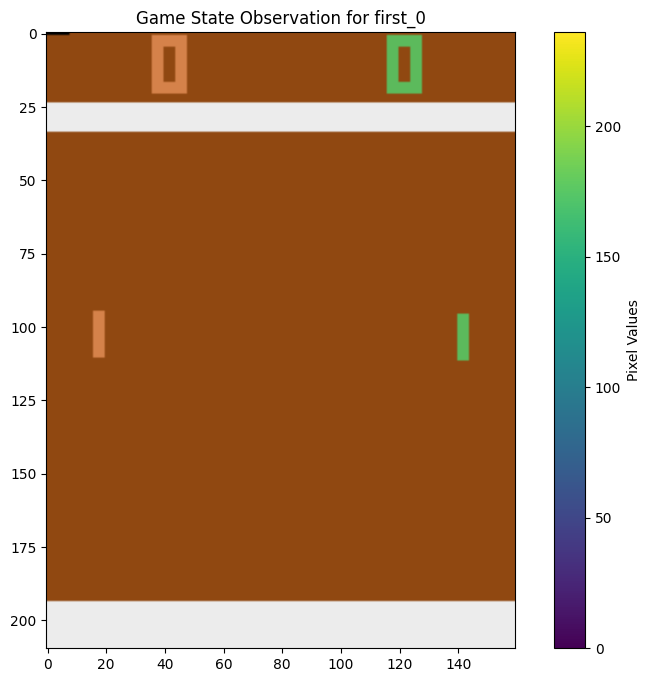

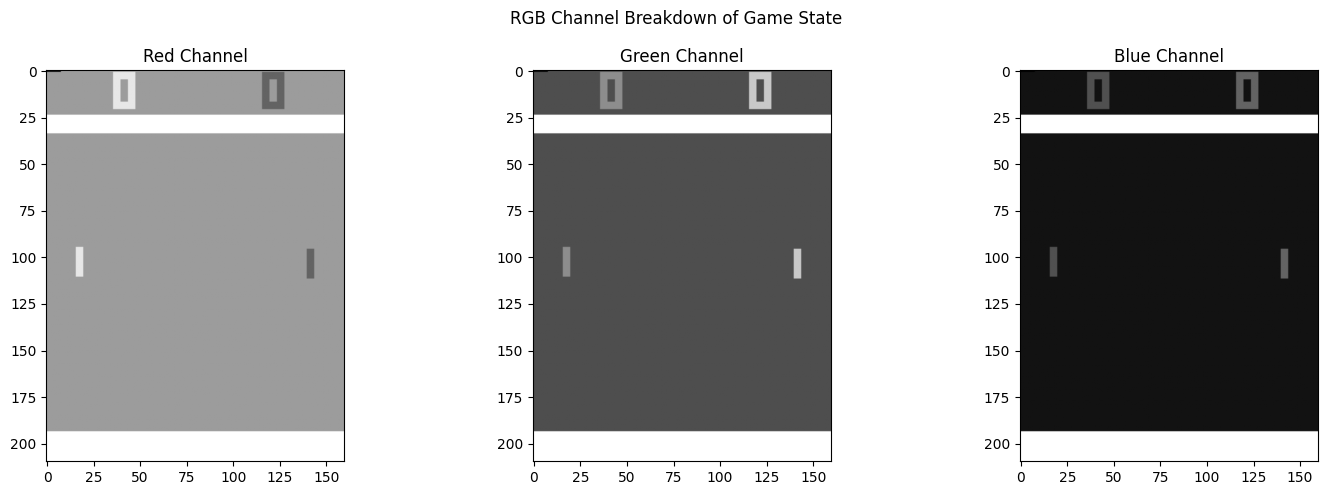

In [4]:
import matplotlib.pyplot as plt
from pettingzoo.atari import pong_v3

# Create and initialize the environment
print("Creating Pong Environment...")
env = pong_v3.env()
env.reset()

# Display environment information
print("\nEnvironment Information:")
print(f"Agents: {env.agents}")
print(f"Action Space: {env.action_space('first_0')}")
print(f"Observation Space: {env.observation_space('first_0')}")

# Get the initial observation for the first agent
observation, reward, terminated, truncated, info = env.last()
agent = env.agents[0]  # Get the first agent

print(f"\nObservation Details for {agent}:")
print(f"Shape: {observation.shape}")
print(f"Value range: [{observation.min()}, {observation.max()}]")
print(f"Reward: {reward}")
print(f"Game Status - Terminated: {terminated}, Truncated: {truncated}")
print(f"Additional Info: {info}")

# Visualize the observation
plt.figure(figsize=(10, 8))
plt.imshow(observation)
plt.title(f'Game State Observation for {agent}')
plt.axis('on')
plt.colorbar(label='Pixel Values')
plt.show()

# Show RGB channels separately
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle(f'RGB Channel Breakdown of Game State')

channels = ['Red', 'Green', 'Blue']
for i, (ax, channel) in enumerate(zip(axes, channels)):
    ax.imshow(observation[:, :, i], cmap='gray')
    ax.set_title(f'{channel} Channel')
    ax.axis('on')

plt.tight_layout()
plt.show()

env.close()

### 2. Agent Implementation

In [5]:
class Agent:
    """Base Agent class for Pong competition."""
    def __init__(self, env, player_name=None):
        self.env = env
        self.player_name = player_name

    def choose_action(self, observation, reward=0.0, terminated=False, truncated=False, info=None):
        """Choose an action based on the current game state."""
        return self.env.action_space(self.player_name).sample()

    def learn(self):
        """Learning method - to be implemented by specific agents."""
        pass

class AgentAlwaysLeft(Agent):
    """Agent that always moves left."""
    def choose_action(self, observation, reward=0.0, terminated=False, truncated=False, info=None):
        """Always choose the 'move left' action (3)."""
        return 3

### 3. Running a Simple Match

In [6]:
def run_match(env, agent1, agent2, max_cycles=500):
    """
    Run a match between two agents and return their cumulative rewards.

    Args:
        env: The game environment
        agent1: First agent
        agent2: Second agent
        max_cycles: Maximum number of cycles before forcing end of game

    Returns:
        tuple: (agent1_reward, agent2_reward) - Cumulative rewards for both agents
    """
    env.reset()

    # Assign player names to agents
    agent1.player_name = env.agents[0]
    agent2.player_name = env.agents[1]

    # Initialize reward tracking
    cumulative_rewards = {
        agent1.player_name: 0,
        agent2.player_name: 0
    }
    nb_step = 0

    for agent in env.agent_iter():
        observation, reward, terminated, truncated, info = env.last()

        # Update cumulative rewards
        cumulative_rewards[agent] += reward

        if terminated or truncated:
            action = None
        else:
            # Choose action based on which agent's turn it is
            if agent == agent1.player_name:
                action = agent1.choose_action(observation, reward, terminated, truncated, info)
            else:
                action = agent2.choose_action(observation, reward, terminated, truncated, info)

        env.step(action)
        nb_step += 1

        if terminated or truncated or nb_step > max_cycles:
            break

    env.close()
    return cumulative_rewards[agent1.player_name], cumulative_rewards[agent2.player_name]

# Create environment and agents
env = pong_v3.env()
random_agent = Agent(env)
always_left_agent = AgentAlwaysLeft(env)

print("\nRunning match: Random Agent vs Always Left Agent")
agent1_reward, agent2_reward = run_match(env, random_agent, always_left_agent)
print(f"Random Agent reward: {agent1_reward}")
print(f"Always Left Agent reward: {agent2_reward}")


Running match: Random Agent vs Always Left Agent
Random Agent reward: 1
Always Left Agent reward: -1


# Evaluate

In [7]:
import numpy as np
from pettingzoo.atari import pong_v3
from typing import Dict, List, Tuple, Type
import time
import random
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Import evaluation function
from pong2024.eval.evaluate_against_multiple_agents import evaluate_against_multiple_agents, visualize_multiple_matchups


# Define example agents for testing
class YourAgent:
    """Example of a custom agent - currently just random actions."""
    def __init__(self, env, player_name=None):
        self.env = env
        self.player_name = player_name

    def choose_action(self, observation, reward=0.0, terminated=False, truncated=False, info=None):
        """Choose action randomly."""
        return self.env.action_space(self.player_name).sample()

class AlwaysLeftAgent:
    """Agent that always moves left."""
    def __init__(self, env, player_name=None):
        self.env = env
        self.player_name = player_name

    def choose_action(self, observation, reward=0.0, terminated=False, truncated=False, info=None):
        """Always choose move left action (3)."""
        return 3

class AlwaysRightAgent:
    """Agent that always moves right."""
    def __init__(self, env, player_name=None):
        self.env = env
        self.player_name = player_name

    def choose_action(self, observation, reward=0.0, terminated=False, truncated=False, info=None):
        """Always choose move right action (2)."""
        return 2

# Create environment
env = pong_v3.env()

# Define list of opponent agents to evaluate against
opponent_agents = [
    AlwaysLeftAgent,   # Deterministic opponent - always moves left
    AlwaysRightAgent,  # Deterministic opponent - always moves right
    YourAgent          # Random opponent
]

print("Starting evaluation against multiple opponents...")

# Run evaluation against all opponents
results = evaluate_against_multiple_agents(
    env=env,
    main_agent_class=YourAgent,        # Your agent to evaluate
    opponent_classes=opponent_agents,   # List of opponents
    n_games_per_matchup=10,            # Number of games per opponent
    max_cycles=100,                  # Maximum steps per game
    seed=42,                            # For reproducibility
    n_verbose_game=1
)

# Print summary results
print("\nEvaluation Summary:")
print(f"Overall win rate: {results['summary']['main_agent_overall_winrate']:.1%}")
print(f"Average score: {results['summary']['main_agent_average_score']:.1f}")

print("\nPerformance against each opponent:")
for matchup in results['matchups']:
    print(f"\nVs {matchup['opponent_class']}:")
    print(f"Win rate: {matchup['main_agent_winrate']:.1%}")
    print(f"Average score: {matchup['main_agent_avg_score']:.1f}")


Starting evaluation against multiple opponents...

Starting evaluation of YourAgent against 3 opponents
--------------------------------------------------------------------------------

Testing against Opponent 1/3: AlwaysLeftAgent
Playing game 1/10
Playing game 2/10
Playing game 3/10
Playing game 4/10
Playing game 5/10
Playing game 6/10
Playing game 7/10
Playing game 8/10
Playing game 9/10
Playing game 10/10

Matchup Summary vs AlwaysLeftAgent:
Wins: 0
Draws: 10
Losses: 0
Win Rate: 0.00%
Draw Rate: 100.00%
Loss Rate: 0.00%

Testing against Opponent 2/3: AlwaysRightAgent
Playing game 1/10
Playing game 2/10
Playing game 3/10
Playing game 4/10
Playing game 5/10
Playing game 6/10
Playing game 7/10
Playing game 8/10
Playing game 9/10
Playing game 10/10

Matchup Summary vs AlwaysRightAgent:
Wins: 0
Draws: 10
Losses: 0
Win Rate: 0.00%
Draw Rate: 100.00%
Loss Rate: 0.00%

Testing against Opponent 3/3: YourAgent
Playing game 1/10
Playing game 2/10
Playing game 3/10
Playing game 4/10
Playing ga

In [ ]:

visualize_multiple_matchups(results)

# Feature Engineering

The raw observation from the Pong environment (210, 160, 3) is quite large and complex,
containing a lot of unnecessary information. We can make learning easier by:

1. Dimension Reduction:
   - Extract play area (removing score/info areas)
   - Convert to grayscale (remove color channels)
   - Resize to smaller dimensions

2. Player Perspective Normalization:
   - The game looks different for player 1 vs player 2
   - Flipping the image for player 2 makes both perspectives similar (but action should be reverse)
   - This helps the agent learn a single strategy for both sides

3. Image Processing:
   - Gaussian smoothing reduces noise
   - Binary thresholding separates objects clearly
   - Normalization scales values to [0,1]

4. Temporal Features:
   - Pong is a dynamic environment
   - Consider using frame differences to capture motion
   - Stack multiple frames to provide temporal context
   - Apply same preprocessing to difference frames
5. Extract more specific information

In [57]:
import cv2
import numpy as np

def collect_game_observations(steps):
    """Collect observations at specified steps using agent iteration."""
    env = pong_v3.env()
    env.reset()

    observations = []
    nb_step = 0

    for agent in env.agent_iter():
        observation, reward, terminated, truncated, info = env.last()

        if nb_step in steps:
            observations.append(observation)

        # If the agent is terminated, pass None as the action
        if terminated or truncated:
            action = None
        else:
            action = env.action_space(agent).sample()

        env.step(action)

        nb_step += 1


    env.close()
    return observations

In [63]:
from pong2024.feature_engineering.feature_engineering import simplified_preprocess_image

def visualize_preprocessing_steps(observation):
    """
    Visualize preprocessing steps: Original -> Play Area -> Grayscale -> Binary
    """
    plt.figure(figsize=(16, 4))

    # Original
    plt.subplot(1, 4, 1)
    plt.imshow(observation)
    plt.title('Original')
    plt.axis('on')

    # Play area
    y_bottom, y_top = 34, 194
    play_area = observation[y_bottom:y_top, :, :]
    plt.subplot(1, 4, 2)
    plt.imshow(play_area)
    plt.title('Play Area')
    plt.axis('on')

    # Grayscale
    gray = cv2.cvtColor(play_area, cv2.COLOR_RGB2GRAY)
    plt.subplot(1, 4, 3)
    plt.imshow(gray, cmap='gray')
    plt.title('Grayscale')
    plt.axis('on')

    # Binary (0,1)
    processed = simplified_preprocess_image(observation)
    print(processed.shape)
    plt.subplot(1, 4, 4)
    plt.imshow(processed, cmap='binary')
    plt.title('Binary')
    plt.axis('on')

    # Verify binary values
    unique_values = np.unique(processed)
    print(f"Unique values in binary output: {unique_values}")

    plt.tight_layout()
    plt.show()

    return


Observation 50:
(32, 32)
Unique values in binary output: [0 1]


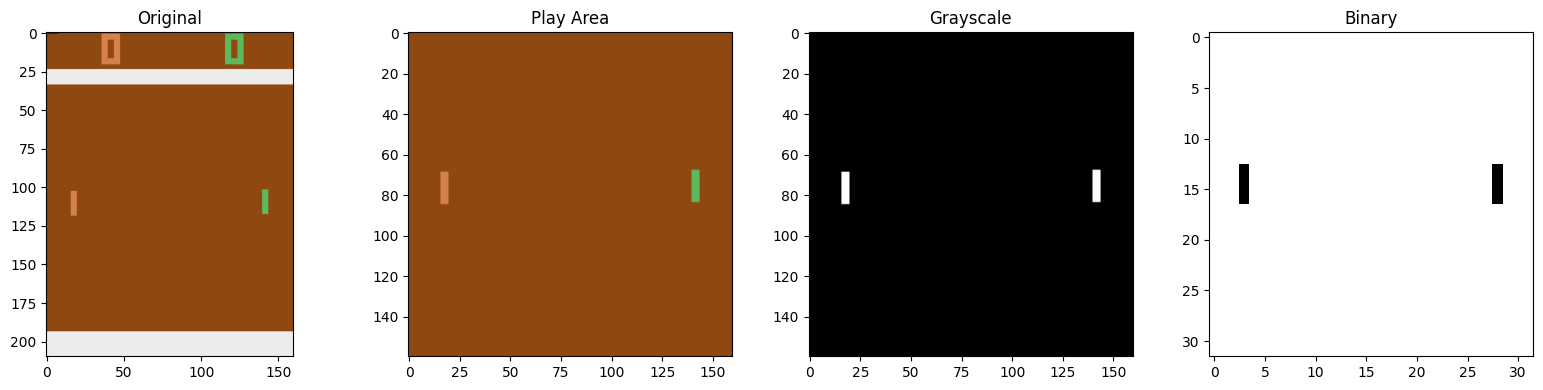


Observation 150:
(32, 32)
Unique values in binary output: [0 1]


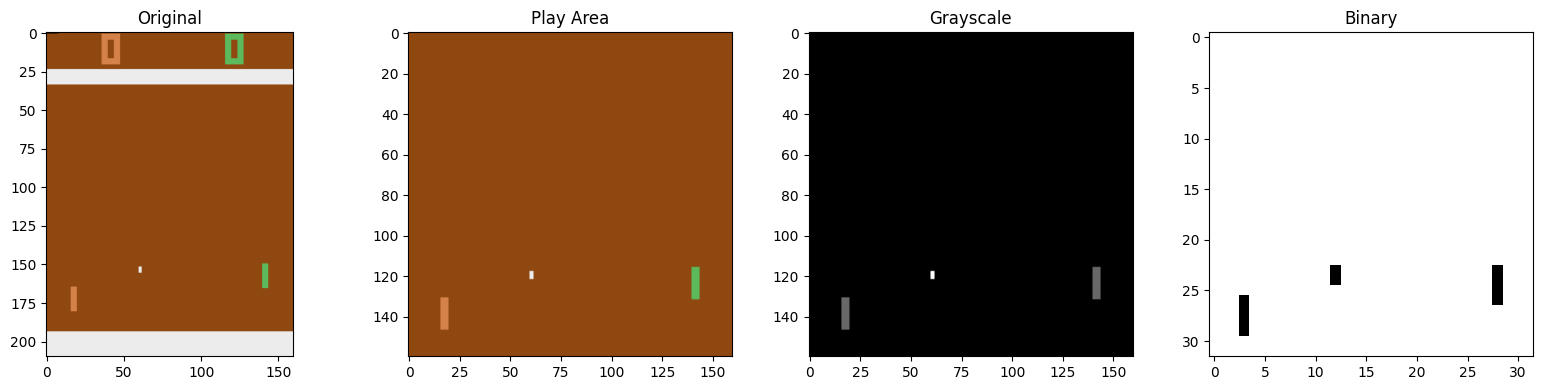


Observation 222:
(32, 32)
Unique values in binary output: [0 1]


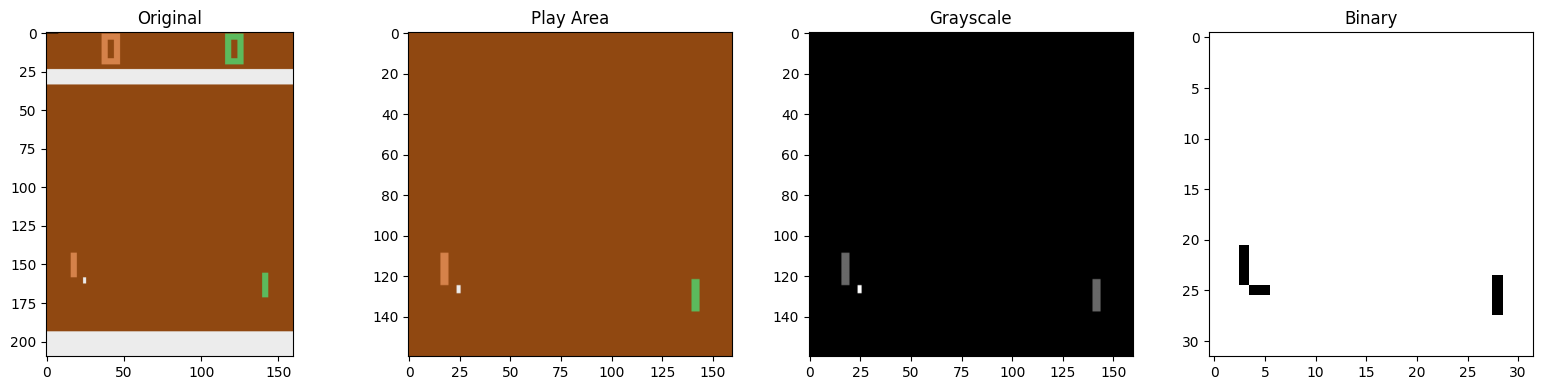

In [64]:
steps = [50,150,222]
# Collect multiple observations
observations = collect_game_observations(steps=steps)

# Visualize preprocessing steps for each observation
for i, obs in enumerate(observations):
    print(f"\nObservation {steps[i]}:")
    visualize_preprocessing_steps(obs)

# Train

In [8]:
class RandomAgent:
    """Base Agent class for Pong competition."""
    def __init__(self, env, player_name=None):
        self.env = env
        self.player_name = player_name

    def choose_action(self, observation, reward=0.0, terminated=False, truncated=False, info=None):
        """Choose an action based on the current game state."""
        return self.env.action_space(self.player_name).sample()

    def learn(self):
        """Learning method - to be implemented by specific agents."""
        pass

In [13]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
import os
from pettingzoo.atari import pong_v3
from pong2024.train.train_sequential import train_sequential
from pong2024.feature_engineering.feature_engineering import simplified_preprocess_image

In [39]:
  # ML-Arena: Pong 2024 - Q-Learning Agent Training
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
import os
from pettingzoo.atari import pong_v3
from pong2024.train.train_sequential import train_sequential
from pong2024.feature_engineering.feature_engineering import simplified_preprocess_image
from datetime import datetime

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import numpy as np
import random
import time
from typing import Type, List, Dict
from concurrent.futures import ThreadPoolExecutor
from copy import deepcopy
import numpy as np
from pettingzoo.atari import pong_v3
from typing import Dict, List, Tuple, Type
import time
import random
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from pong2024.eval import evaluate_agents

class Agent:
    """Base Agent class for Pong competition."""
    def __init__(self, env, player_name = None):
        self.env = env
        self.player_name = player_name

    def choose_action(self, observation, reward=0.0, terminated=False, truncated=False, info=None):
        """Choose an action based on the current game state."""
        return self.env.action_space(self.player_name).sample()


import numpy as np
import random
import time
from typing import Type, List, Dict
from concurrent.futures import ThreadPoolExecutor
from copy import deepcopy

import numpy as np
import random
import time
from typing import Type, List, Dict

def train_sequential(
    make_env,
    main_agent_class: Type[Agent],
    opponent_classes: List[Type[Agent]],
    n_total_episodes: int = 10000,
    eval_frequency: int = 100,
    max_cycles: int = 3000,
    opponent_probs: List[float] = None,
    seed: int = None
) -> Dict:
    """
    Train one main agent against multiple opponent agents sequentially.

    Args:
        make_env: Function that creates a new environment instance
        main_agent_class: The primary agent class to train
        opponent_classes: List of opponent agent classes to train against
        n_total_episodes: Total number of training episodes across all opponents
        eval_frequency: Number of episodes between metric computations
        max_cycles: Maximum number of cycles per episode
        opponent_probs: List of probabilities for selecting each opponent. Must sum to 1.
                       If None, uniform distribution is used.
        seed: Random seed for reproducibility

    Returns:
        Dictionary containing training results and metrics
    """
    if seed is not None:
        np.random.seed(seed)
        random.seed(seed)

    # Initialize opponent probabilities
    if opponent_probs is None:
        opponent_probs = [1.0 / len(opponent_classes)] * len(opponent_classes)
    assert len(opponent_probs) == len(opponent_classes)
    assert abs(sum(opponent_probs) - 1.0) < 1e-6

    # Initialize training results dictionary
    training_results = {
        'opponents': [{
            'opponent_id': idx,
            'opponent_class': opponent_class.__name__,
            'episodes': [],
            'metrics_history': [],
            'win_rate_history': [],
            'draw_rate_history': [],
            'lose_rate_history': []
        } for idx, opponent_class in enumerate(opponent_classes, 1)],
        'summary': {
            'total_episodes': 0,
            'total_training_time': 0
        }
    }

    # Create environment and agents
    env = make_env()
    main_agent = main_agent_class(env)
    opponent_instances = {
        opponent_class.__name__: opponent_class(env)
        for opponent_class in opponent_classes
    }

    start_time = time.time()
    metrics_window = []
    current_window_start = 0

    def select_opponent() -> Type[Agent]:
        """Select opponent based on provided probabilities"""
        return np.random.choice(opponent_classes, p=opponent_probs)

    # Main training loop
    for episode in range(n_total_episodes):
        # Select opponent for this episode
        opponent_class = select_opponent()
        opponent = opponent_instances[opponent_class.__name__]

        env.reset()

        # Randomly assign roles
        possible_players = list(env.possible_agents)
        random.shuffle(possible_players)
        main_agent.player_name = possible_players[0]
        opponent.player_name = possible_players[1]

        agent_mapping = {
            main_agent.player_name: (main_agent, "main_agent"),
            opponent.player_name: (opponent, "opponent")
        }

        # Run single episode
        episode_rewards = {"main_agent": 0, "opponent": 0}
        step_count = 0
        episode_active = True

        # Track current state for experience replay
        current_states = {agent_id: None for agent_id in env.possible_agents}
        current_actions = {agent_id: None for agent_id in env.possible_agents}

        for agent_id in env.agent_iter():
            observation, reward, termination, truncation, info = env.last()
            agent, agent_name = agent_mapping[agent_id]
            episode_rewards[agent_name] += reward

            # Get the done flag
            done = termination or truncation

            if agent_name == "main_agent":
                # Store the previous state-action pair's results if they exist
                if current_states[agent_id] is not None:
                    main_agent.learn(
                        state=current_states[agent_id],
                        action=current_actions[agent_id],
                        reward=reward,
                        next_state=observation,
                        done=done
                    )

            if done:
                action = None
                episode_active = False
            else:
                # Choose and store current state-action pair
                action = agent.choose_action(
                    observation, reward, termination, truncation, info
                )
                if agent_name == "main_agent":
                    current_states[agent_id] = observation
                    current_actions[agent_id] = action

            env.step(action)
            step_count += 1

            if not episode_active or step_count >= max_cycles:
                # Handle final state for the episode if it ended due to max_cycles
                if agent_name == "main_agent" and current_states[agent_id] is not None:
                    main_agent.learn(
                        state=current_states[agent_id],
                        action=current_actions[agent_id],
                        reward=reward,
                        next_state=observation,
                        done=True
                    )
                break

        # Record episode results
        main_score = episode_rewards["main_agent"]
        opponent_score = episode_rewards["opponent"]
        episode_data = {
            "episode": episode + 1,
            "opponent_class": opponent_class.__name__,
            "main_agent_role": main_agent.player_name,
            "main_agent_score": main_score,
            "opponent_score": opponent_score,
            "steps": step_count,
            "win": main_score > opponent_score,
            "draw": main_score == opponent_score,
            "lose": main_score < opponent_score
        }

        # Store episode data
        opponent_idx = next(
            i for i, res in enumerate(training_results['opponents'])
            if res['opponent_class'] == opponent_class.__name__
        )
        training_results['opponents'][opponent_idx]['episodes'].append(episode_data)
        metrics_window.append(episode_data)

        # Compute and display metrics periodically
        if (episode + 1) % eval_frequency == 0 or episode == n_total_episodes - 1:
            window_episodes = metrics_window[current_window_start:]
            current_window_start = len(metrics_window)

            if window_episodes:
                print(f"\nEpisode {episode + 1}/{n_total_episodes}")
                print("=" * 50)

                total_games = len(window_episodes)

                for opponent_results in training_results['opponents']:
                    recent_episodes = [
                        ep for ep in window_episodes
                        if ep['opponent_class'] == opponent_results['opponent_class']
                    ]

                    if recent_episodes:
                        metrics = {
                            "episode": episode + 1,
                            "games": len(recent_episodes),
                            "win_rate": sum(ep['win'] for ep in recent_episodes) / len(recent_episodes),
                            "draw_rate": sum(ep['draw'] for ep in recent_episodes) / len(recent_episodes),
                            "lose_rate": sum(ep['lose'] for ep in recent_episodes) / len(recent_episodes),
                            "avg_score": sum(ep['main_agent_score'] for ep in recent_episodes) / len(recent_episodes),
                            "avg_opponent_score": sum(ep['opponent_score'] for ep in recent_episodes) / len(recent_episodes),
                            "avg_steps": sum(ep['steps'] for ep in recent_episodes) / len(recent_episodes)
                        }

                        opponent_results['metrics_history'].append(metrics)
                        opponent_results['win_rate_history'].append(metrics['win_rate'])
                        opponent_results['draw_rate_history'].append(metrics['draw_rate'])
                        opponent_results['lose_rate_history'].append(metrics['lose_rate'])

                        print(f"\n{opponent_results['opponent_class']}:")
                        print(f"Games: {metrics['games']} ({metrics['games']/total_games:.1%} of total)")
                        print(f"Win Rate: {metrics['win_rate']:.1%}")
                        print(f"Draw Rate: {metrics['draw_rate']:.1%}")
                        print(f"Lose Rate: {metrics['lose_rate']:.1%}")
                        print(f"Avg Score: {metrics['avg_score']:.1f} vs {metrics['avg_opponent_score']:.1f}")

    training_results['summary'].update({
        'total_episodes': n_total_episodes,
        'total_training_time': time.time() - start_time,
        'final_metrics': {
            opponent_results['opponent_class']: opponent_results['metrics_history'][-1]
            if opponent_results['metrics_history'] else None
            for opponent_results in training_results['opponents']
        }
    })

    print("\nTraining Complete!")
    print("=" * 50)
    print(f"Total Training Time: {training_results['summary']['total_training_time']:.1f} seconds")

    return training_results

def visualize_training_results(results: dict):
    """
    Create visualizations for the training results using metrics computed directly from training episodes.

    Args:
        results: Dictionary containing the training results from train_against_multiple_agents
    """
    # Create figure with multiple subplots
    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(2, 2)

    # 1. Learning Curves (Win Rates)
    ax1 = fig.add_subplot(gs[0, 0])

    for opponent_results in results['opponents']:
        metrics_data = pd.DataFrame(opponent_results['metrics_history'])
        ax1.plot(metrics_data['episode'], metrics_data['win_rate'],
                marker='o', label=f"vs {opponent_results['opponent_class']}")

    ax1.set_title('Learning Progress - Win Rates')
    ax1.set_xlabel('Training Episodes')
    ax1.set_ylabel('Win Rate')
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    # 2. Average Scores Over Time
    ax2 = fig.add_subplot(gs[0, 1])

    for opponent_results in results['opponents']:
        metrics_data = pd.DataFrame(opponent_results['metrics_history'])
        ax2.plot(metrics_data['episode'], metrics_data['avg_score'],
                marker='o', label=f"vs {opponent_results['opponent_class']}")

    ax2.set_title('Learning Progress - Average Scores')
    ax2.set_xlabel('Training Episodes')
    ax2.set_ylabel('Average Score')
    ax2.grid(True, alpha=0.3)
    ax2.legend()

    # 3. Average Steps Over Time
    ax3 = fig.add_subplot(gs[1, 0])

    for opponent_results in results['opponents']:
        metrics_data = pd.DataFrame(opponent_results['metrics_history'])
        ax3.plot(metrics_data['episode'], metrics_data['avg_steps'],
                marker='o', label=f"vs {opponent_results['opponent_class']}")

    ax3.set_title('Learning Progress - Average Steps per Episode')
    ax3.set_xlabel('Training Episodes')
    ax3.set_ylabel('Average Steps')
    ax3.grid(True, alpha=0.3)
    ax3.legend()

    # 4. Final Performance Summary
    ax4 = fig.add_subplot(gs[1, 1])

    final_metrics = pd.DataFrame(results['summary']['final_metrics']).T
    final_metrics = final_metrics.reset_index()
    final_metrics.columns = ['Opponent'] + list(final_metrics.columns[1:])

    x = np.arange(len(final_metrics))
    width = 0.25

    # Plot three metrics side by side
    ax4.bar(x - width, final_metrics['win_rate'], width, label='Win Rate')
    ax4.bar(x, final_metrics['avg_score'] / final_metrics['avg_score'].max(),
            width, label='Norm. Avg Score')
    ax4.bar(x + width, final_metrics['avg_steps'] / final_metrics['avg_steps'].max(),
            width, label='Norm. Avg Steps')

    ax4.set_title('Final Performance Summary')
    ax4.set_xticks(x)
    ax4.set_xticklabels(final_metrics['Opponent'], rotation=45)
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Additional plot: Score distributions
    plt.figure(figsize=(12, 6))

    for opponent_results in results['opponents']:
        episodes_df = pd.DataFrame(opponent_results['episodes'])
        sns.kdeplot(data=episodes_df['main_agent_score'],
                   label=f"vs {opponent_results['opponent_class']}")

    plt.title('Distribution of Main Agent Scores During Training')
    plt.xlabel('Score')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [69]:

class QNetwork(nn.Module):
    """Convolutional Q-Network optimized for 32x32 Pong binary input with 2 channels"""
    def __init__(self, n_actions=6):
        super(QNetwork, self).__init__()

        self.conv = nn.Sequential(
            # Input: 2x32x32
            nn.Conv2d(2, 16, kernel_size=3, stride=1, padding=1),  # Output: 16x32x32
            nn.ReLU(),
            nn.MaxPool2d(2),  # Output: 16x16x16

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),  # Output: 32x16x16
            nn.ReLU(),
            nn.MaxPool2d(2),  # Output: 32x8x8

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # Output: 64x8x8
            nn.ReLU()
        )

        # Fixed fc_input_dim for 32x32 input: 64 channels * 8 * 8 = 4096
        self.fc_input_dim = 64 * 8 * 8

        self.fc = nn.Sequential(
            nn.Linear(self.fc_input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, n_actions)
        )

    def forward(self, x):
        if not isinstance(x, torch.Tensor):
            x = torch.FloatTensor(x)
        x = x.float()

        x = self.conv(x)
        x = x.view(x.size(0), -1)  # Flatten to (batch_size, 4096)
        return self.fc(x)

    def get_action(self, state, epsilon=0.0):
        """Helper method to get action with epsilon-greedy policy"""
        if random.random() < epsilon:
            return random.randrange(6)  # Assuming 6 possible actions

        with torch.no_grad():
            state = torch.FloatTensor(state).unsqueeze(0)  # Add batch dimension
            q_values = self(state)
            return q_values.argmax().item()

class QAgent:

    """Q-Learning Agent with 2-Channel Input, Experience Replay, and Action Flipping"""
    def __init__(self, env, player_name=None, auto_load_path=None,
                 auto_save_n_steps=50000, auto_save_suffix="q_agent.pth"):

        self.env = env
        self.player_name = player_name
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Save/Load parameters
        self.auto_save_n_steps = auto_save_n_steps
        self.auto_save_suffix = auto_save_suffix

        # Q-Network and target network
        self.q_network = QNetwork().to(self.device)
        self.target_network = QNetwork().to(self.device)

        # Load pretrained model if available
        if auto_load_path and os.path.exists(auto_load_path):
            print(f"Loading model from {auto_load_path}")
            self.load(auto_load_path)
        else:
            self.target_network.load_state_dict(self.q_network.state_dict())

        self.optimizer = optim.Adam(self.q_network.parameters(), lr=0.0001)
        self.memory = deque(maxlen=10000)

        # Training parameters
        self.batch_size = 32
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.target_update = 1000
        self.steps = 0

        # Store previous observation
        self.previous_observation = None

    def preprocess_frames(self, current_observation, flip=False):
        """Preprocess current frame and combine with previous frame"""
        # Preprocess current frame
        current_frame = simplified_preprocess_image(current_observation, flip=flip)

        # If no previous observation, use zeros
        if self.previous_observation is None:
            previous_frame = np.zeros_like(current_frame)
        else:
            previous_frame = simplified_preprocess_image(self.previous_observation, flip=flip)

        # Stack frames into 2 channels
        stacked_frames = np.stack([current_frame, previous_frame])

        # Update previous observation
        self.previous_observation = current_observation.copy()

        return stacked_frames

    def choose_action(self, observation, reward=0.0, terminated=False, truncated=False, info=None):
        """Choose action using epsilon-greedy policy with 2-channel input"""

        is_second_player = (self.player_name == "second_0")

        # Preprocess and stack frames
        state = self.preprocess_frames(observation, flip=is_second_player)
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)

        if random.random() < self.epsilon:
            return self.env.action_space(self.player_name).sample()

        with torch.no_grad():
            q_values = self.q_network(state)
            return q_values.argmax().item()

    def learn(self, state=None, action=None, reward=None, next_state=None, done=None):
        """Train on a batch from replay memory and optionally add new experience"""
        # Add new experience to memory if provided
        if all(x is not None for x in [state, action, reward, next_state, done]):
            # Preprocess states for consistent format
            processed_state = self.preprocess_frames(state)
            processed_next_state = self.preprocess_frames(next_state)

            # Store transition in replay memory
            self.memory.append((
                processed_state,
                action,
                reward,
                processed_next_state,
                float(done)
            ))

        # Only proceed with learning if we have enough samples
        if len(self.memory) < self.batch_size:
            return

        batch = random.sample(self.memory, self.batch_size)
        state_batch = torch.FloatTensor(np.array([t[0] for t in batch])).to(self.device)
        action_batch = torch.LongTensor(np.array([t[1] for t in batch])).to(self.device)
        reward_batch = torch.FloatTensor(np.array([t[2] for t in batch])).to(self.device)
        next_state_batch = torch.FloatTensor(np.array([t[3] for t in batch])).to(self.device)
        done_batch = torch.FloatTensor(np.array([t[4] for t in batch])).to(self.device)

        # Compute current Q values
        current_q_values = self.q_network(state_batch).gather(1, action_batch.unsqueeze(1))

        # Compute target Q values
        with torch.no_grad():
            next_q_values = self.target_network(next_state_batch).max(1)[0]
            target_q_values = reward_batch + (1 - done_batch) * self.gamma * next_q_values

        # Compute loss and update
        loss = nn.MSELoss()(current_q_values.squeeze(), target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update target network and handle auto-save
        self.steps += 1
        if self.steps % self.target_update == 0:
            self.target_network.load_state_dict(self.q_network.state_dict())
        if self.auto_save_n_steps > 0 and self.steps % self.auto_save_n_steps == 0:
            timestamp = datetime.now().strftime("%Y-%m-%dT%H:%M:%S")
            save_path = f"{timestamp}_{self.auto_save_suffix}"
            self.save(save_path)
            print(f"Auto-saved model to {save_path}")

        # Decay epsilon
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

    def save(self, path):
        """Save model state"""
        torch.save({
            'q_network_state_dict': self.q_network.state_dict(),
            'target_network_state_dict': self.target_network.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'epsilon': self.epsilon,
            'steps': self.steps
        }, path)

    def load(self, path):
        """Load model state"""
        checkpoint = torch.load(path)
        self.q_network.load_state_dict(checkpoint['q_network_state_dict'])
        self.target_network.load_state_dict(checkpoint['target_network_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.epsilon = checkpoint['epsilon']
        self.steps = checkpoint['steps']

In [70]:
# Training setup
def make_env():
    return pong_v3.env()

# Define opponents with their probabilities
opponent_classes = [RandomAgent]
opponent_probs = [1]  # 90% Random, 10% AlwaysLeft

# Train the agent
print("Starting training...")
results = train_sequential(
    make_env=make_env,
    main_agent_class=QAgent,
    opponent_classes=opponent_classes,
    opponent_probs=opponent_probs,
    n_total_episodes=10000,  # Total training episodes
    eval_frequency=10,      # Evaluate every 100 episodes
    max_cycles=10000         # Max steps per episode
)

Starting training...


KeyboardInterrupt: 